In [1]:
import os
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import seaborn as sns


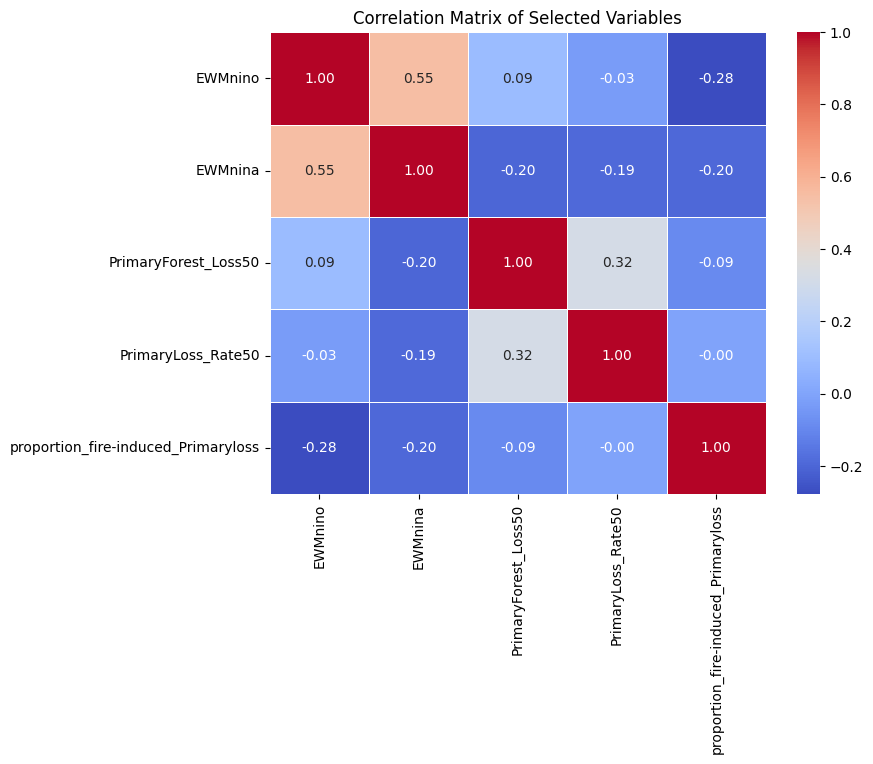

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


Explained variance ratio:
 [0.35017412 0.2749575  0.16240722 0.13660897 0.07585219]
Explained variance ratio:
 [0.35017412 0.2749575  0.16240722 0.13660897 0.07585219]
PCA loadings saved as 'outputs/csv/pca_loadings.csv' ✅
PCA-transformed data with Clusters saved as 'outputs/csv/pca_reduced_data_with_clusters.csv' ✅
pca_loadings:
                                           PC1       PC2       PC3       PC4  \
EWMnino                              0.597697  0.285939  0.316264 -0.141242   
EWMnina                              0.643502 -0.060690  0.322309  0.116705   
PrimaryForest_Loss50                -0.163249  0.676204  0.045454 -0.649332   
PrimaryLoss_Rate50                  -0.256275  0.581384  0.319431  0.702695   
proportion_fire-induced_Primaryloss -0.369238 -0.345394  0.831860 -0.225871   

                                          PC5  
EWMnino                             -0.664097  
EWMnina                              0.681703  
PrimaryForest_Loss50                 0.303973  


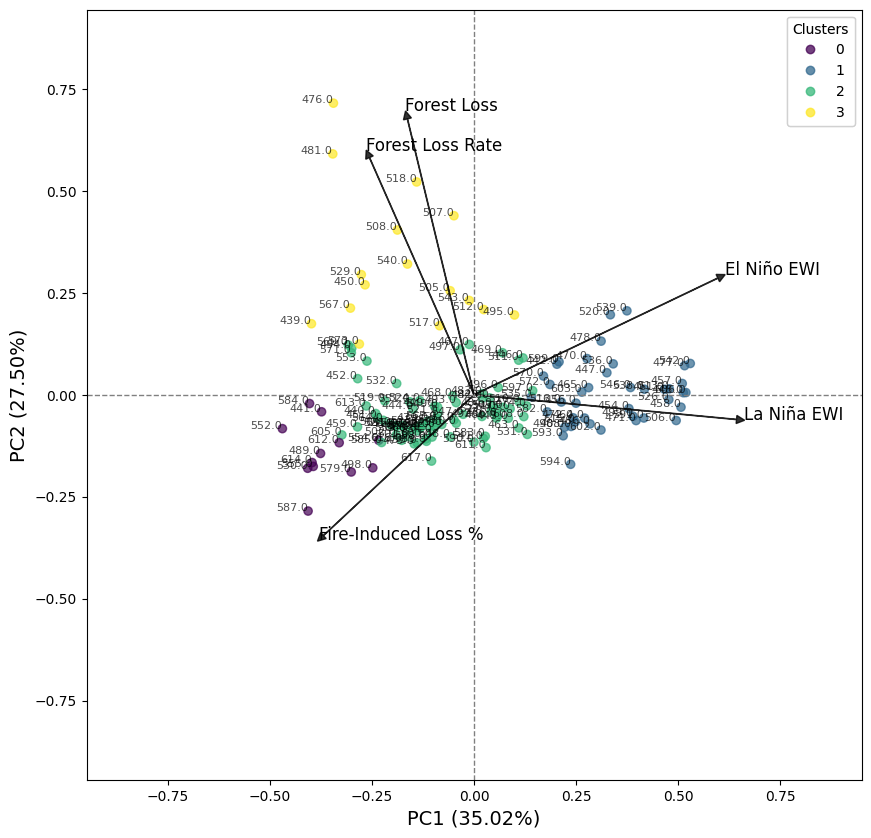

In [5]:

def perform_pca(dataframe, columns, variance_threshold=0.9, n_components=5, n_clusters=4):
    """
    Perform PCA on selected columns of a dataframe and apply K-Means clustering.
    """

    # Select relevant columns but retain index
    df = dataframe[columns].copy()
    
    # Drop rows with missing values while keeping track of the retained ECO_IDs
    df = df.dropna()
    # df = df.fillna(0)
    retained_indices = df.index  # Save ECO_IDs of remaining rows

    # correlation matrix
    corr_matrix = df.corr()
    corr_matrix.to_csv("outputs/csv/correlation_matrix.csv")    
    # Plot correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(
        corr_matrix, 
        annot=True, 
        cmap="coolwarm", 
        fmt=".2f", 
        linewidths=0.5
        )
    plt.title("Correlation Matrix of Selected Variables")
    plt.show()

    # Standardize the data
    scaler = StandardScaler()
    df_scaled = scaler.fit_transform(df)

    # Perform PCA with the specified number of components
    pca = PCA(n_components=n_components)
    reduced_data = pca.fit_transform(df_scaled)

    # Explained variance ratio
    explained_variance_ratio = pca.explained_variance_ratio_
    print("Explained variance ratio:\n", explained_variance_ratio)
    explained_variance = pca.explained_variance_
    print("Explained variance ratio:\n", explained_variance/np.sum(explained_variance))
    # Compute explained variance percentages
    explained_var_pc1 = explained_variance_ratio[0] * 100  # Percentage for PC1
    explained_var_pc2 = explained_variance_ratio[1] * 100  # Percentage for PC2

    # Principal component loadings (eigenvectors)
    pca_loadings = pca.components_
        # ✅ Save PCA loadings to CSV for later use
    loadings_df = pd.DataFrame(
        pca_loadings.T,  # Transpose so features are rows
        columns=[f"PC{i+1}" for i in range(n_components)],
        index=columns  # Assign feature names to rows
    )
    loadings_df.to_csv("outputs/csv/pca_loadings.csv")  
    print("PCA loadings saved as 'outputs/csv/pca_loadings.csv' ✅")

    # Convert PCA-transformed data into a DataFrame
    PC_scores = pd.DataFrame(
        reduced_data,
        columns=[f"PC{i+1}" for i in range(n_components)]
        )
        # STEP 3. BIPLOTV
    PC1 = pca.fit_transform(df_scaled)[:,0]
    PC2 = pca.fit_transform(df_scaled)[:,1]
    
    scalePC1 = 1.0/(PC1.max() - PC1.min())
    scalePC2 = 1.0/(PC2.max() - PC2.min())

    # ✅ Apply K-Means Clustering on the PCA-transformed data
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(reduced_data)

    # ✅ Add cluster labels to the DataFrame
    PC_scores["Cluster"] = clusters


    return PC_scores, explained_variance_ratio, pca_loadings, retained_indices, pca


def plot_pca_clusters(PC_scores, pca_loadings, explained_variance, pc_x=1, pc_y=2):
    """
    Plots PCA clusters for different PC combinations dynamically with scaling.
    """
    pc_x -= 1  # Adjust index (PC1 -> index 0, PC2 -> index 1, etc.)
    pc_y -= 1

    # ✅ Drop NaN values
    PC_scores = PC_scores.dropna()

    # ✅ Adjust column indices (skip 'ECO_ID')
    pc_x += 1  
    pc_y += 1  

    # ✅ Print available columns
    print("Columns in PC_scores:", PC_scores.columns)

    # Compute explained variance percentages
    explained_var_x = explained_variance[pc_x - 1] * 100
    explained_var_y = explained_variance[pc_y - 1] * 100

    # ✅ Compute correct min/max values for scaling
    min_x, max_x = PC_scores.iloc[:, pc_x].min(), PC_scores.iloc[:, pc_x].max()
    min_y, max_y = PC_scores.iloc[:, pc_y].min(), PC_scores.iloc[:, pc_y].max()

    # ✅ Print min/max for debugging
    print(f"PC{pc_x} min/max: {min_x}, {max_x}")
    print(f"PC{pc_y} min/max: {min_y}, {max_y}")

    # ✅ Adjust scaling factors (increase factor to avoid collapsing)
    scalePC_x = 1.0 / (max_x - min_x) if max_x - min_x != 0 else 1
    scalePC_y = 1.0 / (max_y - min_y) if max_y - min_y != 0 else 1
    print(f"Scaling factors - X: {scalePC_x}, Y: {scalePC_y}")


    # ✅ Plot
    fig, ax = plt.subplots(figsize=(10, 10))

    # ✅ Ensure 'Cluster' exists before using it
    if 'Cluster' in PC_scores.columns:
        clusters = PC_scores['Cluster']
    else:
        print("Warning: 'Cluster' column not found! Using default.")
        clusters = None  # Avoid crashing

    # ✅ Fix scatter plot: Proper column selection, remove scaling temporarily
    scatter = ax.scatter(
        PC_scores.iloc[:, pc_x] * scalePC_x,
        PC_scores.iloc[:, pc_y] * scalePC_y, 
        c=clusters, 
        cmap='viridis', 
        alpha=0.7,
    )



    # ✅ Add legend if clusters exist
    if clusters is not None:
        legend1 = ax.legend(*scatter.legend_elements(), title="Clusters")
        ax.add_artist(legend1)


    # ✅ Plot PCA vectors (loadings)
    features = [
        'El Niño EWI',
        'La Niña EWI',
        'Forest Loss',
        'Forest Loss Rate',
        'Fire-Induced Loss %'
        ]

    for i, feature in enumerate(features):
        ax.arrow(
            0, 
            0, 
            pca_loadings[pc_x - 1, i], 
            pca_loadings[pc_y - 1, i],
            color='black', 
            alpha=0.8, 
            head_width=0.02, 
            head_length=0.02
            )
        ax.text(
            pca_loadings[pc_x - 1, i] * 1.03,
            pca_loadings[pc_y - 1, i] * 1.03,
            feature,
            fontsize=12
            )

    # ✅ Annotate ECO_ID labels on the biplot
    for i, row in PC_scores.iterrows():
        ax.text(
            row.iloc[pc_x] * scalePC_x, 
            row.iloc[pc_y] * scalePC_y, 
            str(row["ECO_ID"]),
            fontsize=8,
            ha='right', 
            alpha=0.7, 
            color='black'
            )

    # ✅ Set axis limits and aspect ratio
    ax.set_xlim(-0.95, 0.95)
    ax.set_ylim(-0.95, 0.95)
    ax.set_aspect('equal', adjustable='datalim')

    # ✅ Add reference lines at (0,0)
    ax.axhline(0, color='gray', linestyle='--', linewidth=1)
    ax.axvline(0, color='gray', linestyle='--', linewidth=1)

    # ✅ Set axis labels with explained variance
    ax.set_xlabel(f'PC{pc_x} ({explained_var_x:.2f}%)', fontsize=14)
    ax.set_ylabel(f'PC{pc_y} ({explained_var_y:.2f}%)', fontsize=14)

    # Export the plot
    # Define the directory where the file will be saved
    output_dir = "./outputs/figures/"
    # Create the directory if it does not exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir, exist_ok=True)
    plt.savefig(
        os.path.join(output_dir, f"PC{pc_x}_vs_PC{pc_y}.png"), 
        dpi=300,
        bbox_inches='tight'
        )

    # Show plot
    plt.show()


def run():
    # Example usage
    # path_gpkg = "outputs/geopackages/ZonalStat_Ecoregions_EWM_v2.gpkg"
    # layer_name = "zonal_statistics_v2"
    path_gpkg = "outputs/geopackages/ZonalStat_Ecoregions_EWM.gpkg"
    layer_name = "ZonalStat_Ecoregions"

    # Load the GeoPackage file
    ecoregions_gdf = gpd.read_file(path_gpkg, layer=layer_name)

    # Convert to pandas DataFrame and set ECO_ID as index
    ecoregions_df = pd.DataFrame(ecoregions_gdf)
    
    # Drop ecoregions where PrimaryForest is 0
    ecoregions_df = ecoregions_df.drop(
        ecoregions_df[ecoregions_df["PrimaryForest50"] == 0].index
        )

    ecoregions_df.set_index("ECO_ID", inplace=True)  # Ensure ECO_ID is the index

    selected_columns = [
        "EWMnino",
        "EWMnina",
        "PrimaryForest_Loss50",
        "PrimaryLoss_Rate50",
        "proportion_fire-induced_Primaryloss"
    ]

    # Perform PCA with K-Means clustering (e.g., 3 clusters)
    pc_analysis = perform_pca(
        ecoregions_df, 
        selected_columns, 
        variance_threshold = 0.9,
        n_components=5, 
        n_clusters=4
    )
    reduced_data = pc_analysis[0]
    variance_ratios = pc_analysis[1]
    pca_loadings = pc_analysis[2]
    retained_indices = pc_analysis[3]
    pca_model = pc_analysis[4]

    # Add back ECO_IDs from retained indices
    reduced_data.insert(0, "ECO_ID", retained_indices)  # Ensures ECO_ID is the first column

    # Save the PCA-transformed data with Clusters and ECO_ID
    reduced_data.to_csv(
        "outputs/csv/pca_reduced_data_with_clusters.csv", 
        index=False
        )
    print("PCA-transformed data with Clusters saved as 'outputs/csv/pca_reduced_data_with_clusters.csv' ✅")

    # Save the PCA Loadings
    # convert to dataframe
    df_pca_loadings = pd.DataFrame(pca_loadings)

    # add column names
    df_pca_loadings.columns = selected_columns
    # add row names
    df_pca_loadings.index = ["PC1", "PC2", "PC3", "PC4", "PC5"]
    print("pca_loadings:\n", df_pca_loadings.T)
    df_pca_loadings.T.to_csv(
        "outputs/csv/pca_loadings.csv", 
        index=True
    )
    print("PCA Loadings saved as 'outputs/csv/pca_loadings.csv' ✅")

    # cluster_labels = {
    #     0: "Climate-Driven Regions",
    #     1: "Highly Deforested Areas",
    #     2: "Fire-Affected Forests",
    #     # 3: "Moderately Disturbed Regions"
    # }
    
    # plot_elbow_method(reduced_data)  # Use PCA-reduced data
    plot_pca_clusters(
        reduced_data, 
        pca_loadings, 
        variance_ratios, 
        pc_x=1, 
        pc_y=2,
        )

    # optimal_k = determine_optimal_clusters(reduced_data, min_clusters=2, max_clusters=10)
    # plot_explained_variance(pca_model)


if __name__ == "__main__":
    run()

